In [ ]:
!pip install d2l==1.0.0-alpha1.post0

# 데이터셋

In [1]:
# pytorch api를 간단히 다루기 위한 많은 기능이 있음
from d2l import torch as d2l

In [2]:
%matplotlib inline
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

# PASCAL VOC2012 dataset
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
# ../data/VOCdevkit/VOC2012 위치에 추출
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
# 해당 함수는 모든 input image와 label을 읽어들이는 기능을 한다.
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

In [4]:
print('총 데이터 개수 : ',len(train_features))
print('0번 데이터의 크기 : ',train_features[0].shape,', 0번 라벨의 크기 : ',train_labels[0].shape)
print('2번 데이터의 크기 : ',train_features[2].shape,', 2번 라벨의 크기 : ',train_labels[2].shape)
print('10번 데이터의 크기 : ',train_features[10].shape,', 10번 라벨의 크기 : ',train_labels[10].shape)

총 데이터 개수 :  1464
0번 데이터의 크기 :  torch.Size([3, 281, 500]) , 0번 라벨의 크기 :  torch.Size([3, 281, 500])
2번 데이터의 크기 :  torch.Size([3, 375, 500]) , 2번 라벨의 크기 :  torch.Size([3, 375, 500])
10번 데이터의 크기 :  torch.Size([3, 333, 500]) , 10번 라벨의 크기 :  torch.Size([3, 333, 500])


(-0.5, 499.5, 332.5, -0.5)

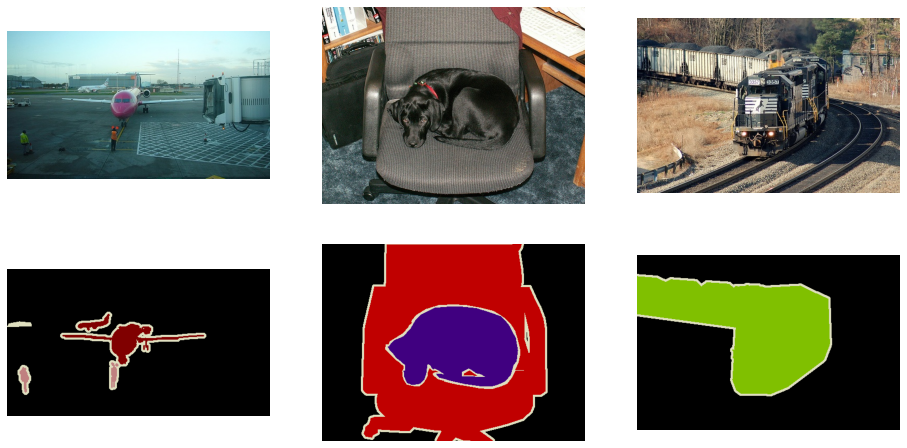

In [19]:
# 예시

fig,axes = plt.subplots(2,3,figsize=(16,8))

axes[0,0].imshow(np.transpose(train_features[0],(1,2,0)))
axes[0,0].axis('off')
axes[1,0].imshow(np.transpose(train_labels[0],(1,2,0)))
axes[1,0].axis('off')
axes[0,1].imshow(np.transpose(train_features[2],(1,2,0)))
axes[0,1].axis('off')
axes[1,1].imshow(np.transpose(train_labels[2],(1,2,0)))
axes[1,1].axis('off')
axes[0,2].imshow(np.transpose(train_features[10],(1,2,0)))
axes[0,2].axis('off')
axes[1,2].imshow(np.transpose(train_labels[10],(1,2,0)))
axes[1,2].axis('off')

In [5]:
# 해당 데이터 세트의 모든 라벨에 대한 RGB 색상 값과 클래스를 열거
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
               
# RGB 값에서 class index를 매핑하는 함수
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

# Pascal VOC2012 데이터 세트의 클래스 인덱스에 RGB 값을 매칭하는 함수
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [23]:
# i-th channel values
i=0
train_labels[0][i][105:115,130:140]

tensor([[  0,   0, 224, 224, 224, 224, 224, 224, 224, 128],
        [  0, 224, 224, 224, 224, 224, 224, 128, 128, 128],
        [  0, 224, 224, 224, 224, 224, 128, 128, 128, 128],
        [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
        [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
        [224, 224, 224, 224, 128, 128, 128, 128, 128, 128],
        [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
        [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
        [  0, 224, 224, 224, 224, 224, 128, 128, 128, 128],
        [  0, 224, 224, 224, 224, 224, 224, 224, 128, 128]], dtype=torch.uint8)

In [6]:
# 비행기의 앞부분 클래스의 인덱스는 1, 배경 인덱스는 0
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]), 'aeroplane')

# Data Preprocessing

모델에 필요한 입력 모양에 맞게 이미지의 크기가 조정되는 것이 보통이지만 semantic segmantation에서는 예측된 픽셀 클래스를 입력 이미지의 원래 모양으로 다시 scaling해야한다. 이러한 rescaling은 특히 다른 클래스의 segment에 대해 부정확할 수 있다. 이런 문제를 피하기 위해 rescaling하는 대신 고정된 모양으로 잘라낸다. (random cropping)

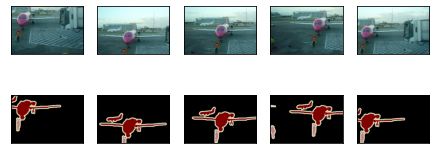

In [7]:
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label
    
n=5
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### [**Custom Semantic Segmentation Dataset Class**]

pytorch에서 high-level API로 제공되는 Dataset class를 상속함으로써 custom semantic segmentation dataset class인 VOCSegDataset을 정의한다. __getitem__ 메서드를 수정함으로써 idx로서 데이터셋에서 인덱스화된 input image와 각 픽셀의 클래스 인덱스에 임의로 접근할 수 있다. 데이터셋의 일부 이미지는 random cropping 출력보다 작기 때문에 이런 이미지는 filter 함수라는 custom 기능에 의해 제외된다. 추가로 normalize_image 함수를 두어 각 input image의 각 채널별 standardize를 수행한다.


In [8]:
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### [**Reading the Dataset**]

'VOCSegDataset' class를 이용해 training set와 test set의 인스턴스를 각각 만든다. random cropping된 이미지는 $320\times 480$으로 한다.

In [9]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [10]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, 
                                    drop_last=True,shuffle=True)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, 
                                    drop_last=True)
# 미니배치 크기 하나 출력
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


### [**Putting All Things Together**]

마지막으로 Pascal VOC2012 semantic segmentation dataset을 data loader형태로 다운로드 하는 함수를 정의한다. 이 함수는 training과 test dataset를 반환한다.

In [10]:
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,drop_last=True,shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True)
    return train_iter, test_iter

# 14.10 Transposed Convolution (Deconvolution)

## Basic Operation

일단 channel은 무시한채 stride=1이고 padding이 없는 기본적인 transposed convolution operation을 살펴보도록 한다. $n_h \times n_w$의 크기를 갖는 input tensor와 $k_h \times k_w$의 크기를 갖는 kernel이 있다고 가정하자. kernel window는 각각 행과 열 방향으로 $n_h$번, $n_w$번 이동하는데 총 $n_h n_w$개의 중간 결과를 만들어내게 된다. 각각의 중간 결과는 $(n_h + k_h - 1) \times (n_w + k_w - 1)$ 크기의 0으로 초기화된 tensor이다. 각 중간 결과를 계산하기 위해서는 input tensor의 각 element가 kernel과 곱해지고, 그러한 결과로 $k_h \times k_w$  tensor를 만들어내는데 각 중간 결과의 부분을 대체하게 된다. 각 중간 텐서(결과)에서 교체된 부분의 위치는 계산에 사용된 input tensor의 요소 위치에 해당한다. 최종적으로 모든 모든 중간 결과를 집계하여 출력을 생성한다.

다음 그림은 어떻게 $2\times 2$ kernel을 가진 transposed convolution가  $2\times 2$ input tensor를 계산하는지 나타낸다.


![tt](http://d2l.ai/_images/trans_conv.svg)

In [32]:
# input matrix X와 kernel matrix K에 대해 transoposed convolution operation을 구현할 수 있다.
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [33]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

또는 input X와 kernel K가 둘다 4차원 tensor일 때, pytorch에서 제공되는 high-level API를 사용하여 동일한 결과를 얻을 수 있다.

In [36]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

## [**Padding, Strides, and Multiple Channels**]

입력에 padding이 적용되는 일반 convolution과 달리 transposed convolution은 output에 padding을 적용한다. 예를 들어 높이과 너비의 양쪽 padding 번호를 1로 지정하면 첫 번째 및 마지막 행과 열이 transposed된 convolution 출력에서 제거된다.

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

transposed convolution에서 stride는 입력이 아닌 중간결과(출력)에 대해 지정된 것이다. 위에서 본 그림과 마찬가지로 $2\times 2$ kernel을 가진 transposed convolution가  $2\times 2$ input tensor에 대해 stride 2일 때 어떻게 동작하는지 나타낸 것인데 중간결과의 높이와 무게가 모두 증가한다.



![ttt](http://d2l.ai/_images/trans_conv_stride2.svg)

다음 코드는 이러한 연산의 결과를 나타낸다.


In [38]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

여러 channel을 갖는 input과 output에 대해 transposed convolution은 일반 convolution과 동일한 방식으로 동작한다. 입력이 $c_i$개의 channel이 있다고 가정하면 transposed convolution은 $k_h\times k_w$ 모양의 kernel을 각각의 input channel에 적용한다. 만일 output channel이 여러 개로 지정되면, $c_i\times k_h\times k_w$의 kernel이 각 output channel마다 생성된다.

마찬가지로, 우리가 $X$를 convolutional layer $f$를 넣어 output $Y=f(X)$을 얻고 $f$와 output channel의 수를 제외한 모든 parameter가 같은 transposed convolutional layer $g$를 생성한다면, $g(Y)$는 X와 같은 shape를 같게 된다.

In [39]:
X = torch.rand(size=(1, 10, 16, 16))
# input과 output의 channel만 반대이고 나머지 hyperparameters는 모두 동일한 convolution layer, transoposed convolution layer
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
print('X의 shape : ',X.shape)
print('g(f(X))의 shape : ',tconv(conv(X)).shape)

X의 shape :  torch.Size([1, 10, 16, 16])
g(f(X))의 shape :  torch.Size([1, 10, 16, 16])


## [**Connection to Matrix Transposition**]

transposed convolution는 행렬 전치에서 따와 명명되었다. 이를 설명하기 위해 우선 행렬 곱셈을 사용하여 convolution을 구현하는 방법을 살펴보도록 한다.
$3\times 3$ input X와 $2\times 2$ kernel K를 정의한다. 그리고 corr2d 함수를 사용하여 convolution output Y를 계산한다.

In [40]:
from IPython.display import display
X = torch.arange(9.0).reshape(3, 3)
display(X)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
display(K)
Y = d2l.corr2d(X, K)
display(Y)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

tensor([[1., 2.],
        [3., 4.]])

tensor([[27., 37.],
        [57., 67.]])

다음으로 convolution kernel K를 0이 대량 포함된 희소한 weight matrix(가중치 행렬) W로써 다시 쓴다. weight matrix의 shape은 (4,9)이인데 convolution kernel K에서 0이 아닌 원소들이 나온 것이다.

In [41]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

display(K)
W = kernel2matrix(K)
display(W)

tensor([[1., 2.],
        [3., 4.]])

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

X를 row by row로 연결해 길이 9짜리 벡터를 얻는다. W와 벡터화된 X의 행렬 곱은 길이 4의 벡터를 나타낸다. reshape 후에 같은 모양의 출력 Y를 보통의 convolution operation으로부터 얻을 수 있다. 우리는 방금 행렬곱을 사용해 convolution을 구현하였다.


In [42]:
display(X.reshape(-1))
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])

tensor([[True, True],
        [True, True]])

마찬가지로 행렬 곱셈을 사용하여 transposed convolution을 구현할 수 있다. 다음 예에서 (위의 예에서 일반 convolution의 output인) $2\times 2$ Y를 transoposed convolution의 input으로써 취한다. 행렬들을 곱하여 이 연산을 구현하기 위해서는 weight matrix W만 (9,4)로 전치하면 된다.

In [43]:
# Y는 일반 convolution layer의 output
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

행렬을 곱하여 convolution을 구현하는 것을 고려해보자. convolution의 forwardpropagation 함수는 input vector $\mathbf{x}$와 weight matrix $\mathbf{W}$를 곱하여 $\mathbf{y}=\mathbf{W}\mathbf{x}$로 표현할 수 있다. backpropagation이 chain rule을 따르고 $\nabla_{\mathbf{x}}\mathbf{y}=\mathbf{W}^\top$이기 때문에 backpropagation 함수는 이 함수의 input과 전치된 weight matrix $\mathbf{W}^\top$를 곱함으로써 구현될 수 있다. 그러므로 transposed convolution layer는 단지 convolutional layer의 forwardpropagation과 backpropagation을 맞바꾼 것으로 볼 수 있다.(순전파와 역전파 시 input vector에 각각 $\mathbf{W}^\top$와 $\mathbf{W}$를 곱해준다.)

# Fully Convolutional Networks

semantic segmentation은 이미지를 픽셀 수준으로 분류한다. fully convolutional network(FCN)는 이미지 픽셀을 픽셀 클래스로 변환하기 위해 convolutional neural network를 사용한다.

이미지 분류 또는 객체 감지를 위한 다른 일반적인 CNN들과 달리, FCN은 transposed convolutional layer를 통해 중간 feature map들의 높이와 폭을 input image의 높이와 폭으로 변환한다.

결과적으로, classification output과 입력 이미지는 픽셀 수준에서 일대일 대응된다. 임의의 output pixel에서 channel dimension은 input image의 pixel과 동일한 위치에서 classification 결과를 갖게 된다.

## The Model

FCN 모델의 디자인을 다음과 같다. 아래 그림과 같이 CNN을 사용하여 이미지 feaure를 추출한 다음, channel 수를 $1\times 1$ convolutionanl layer를 통해 class 수로 변환하고, 마지막으로 transposed convolution을 통해 입력 이미지와 동일한 width와 height가 되도록 모델의 output을 변환한다.

결과적으로, 모델 input과 output 이미지는 동일한 크기를 지니며, output channel은 동일한 공간 위치(spatial position)에서 입력 pixel에 대한 예측 클래스를 포함한다.

![Fully convolutional network.](http://d2l.ai/_images/fcn.svg)

ImageNet 데이터셋으로 사전 훈련된 ResNet-18 모델을 사용해 feature extract를 수행한다. 마지막 몇개의 layer들은 global pooling layer와 fully connected layer인데 이것들은 FCN에서 필요하지는 않으므로 제거하도록 한다.


In [11]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# 마지막 계층(-1번째)은 fully connected layer
print(list(pretrained_net.children())[-1])

net = nn.Sequential(*list(pretrained_net.children())[:-2])

Linear(in_features=512, out_features=1000, bias=True)


In [13]:
# height 320, width 480인 input image에 대해 우리가 정의한 model의 forward propagation은 input의 1/32, 즉 10과 15로 감소시킨다.
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

다음으로, $1\times 1$ convolutional layer를 사용해 output의 channel 수를 데이터셋(Pascal VOC2012)의 class수인 21로 변환한다. 마지막으로, feature map의 width와 height를 32배 증가시켜 input 이미지와 같은 모양으로 다시 변경해야 합니다.



kernel height와 width를 64, padding을 16, stride를 32로 하여 transposed convolutional layer를 구성한다.

(참고 section7.3 convolution layer의 output shape을 계산하는 방법)<br>
$(320-64+16\times2+32)/32=10$ 와 $(480-64+16\times2+32)/32=15$ <br>
일반적으로 stride $s$의 경우, padding $s/2$ ($s/2$가 정수라고 가정)와 height와 width가 $2*s$인 kernel을 가진 transposed convolution은 input의 height와 width를 $s$배로 증가시킨다는 것을 알 수 있다.

In [14]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

## **Initializing Transposed Convolutional Layers**

transposed convolutional layer가 feature map의 height와 width를 증가시킬 수 있다는 것을 이미 알고 있다. image processing에서는 upsampling과 같은 scale up할 필요가 있다. Bilinear interpolation(쌍선형 보간)은 upsampling 테크닉 중 하나이다. 이 기법은 transposed convolutional layer를 초기화하는데에 쓰이기도 한다.

bilinear 보간에 대해 얘기하기 위해 upsampling된 output 이미지의 각 pixel에 대해 계산하려고 하는 input image가 주어져있다 해보자. output image의 좌표 $(x,y)$의 pixel에 대해 계산하고자 할 때, 우선 $(x,y)$를 input image의 좌표 $(x', y')$에 mapping한다. (예를 들어 input size와 output size의 비율에 따라)

이때 $(x', y')$는 각각 실수이고 이 $(x', y')$와 가장 가까운 4개의 좌표를 input image에서 찾도록 한다. 

마지막으로 output의 pixel $(x,y)$는 input image의 $(x', y')$에서 가장 가까운 4개의 pixel과 상대적인 거리에 기반해 계산된다.

bilinear interpolation의 업샘플링은 다음의 bilinear_kernel 함수에 의해 구성된 kernel을 가진 transposed convolutional layer에 의해 구현된다.

In [15]:
# 해당 알고리즘의 상세 과정은 생략
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

transposed convolutional layer에 의해 구현되는 **bilinear interpolation의 upsampling을 실험해보도록 한다. height와 weight를 배로 증가시키는 transposed convolutional layer를 설계하고 구현된 함수를 통해 kernel을 initialize하도록 한다.

In [16]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
# ;는 출력 생략
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [17]:
# input image X를 읽어들이고 upsampling된 output을 Y에 할당한다.

img = torchvision.transforms.ToTensor()(Image.open('catdog.jpg'))
# 이미지 출력을 위한 channel dimension의 위치 조정
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

transposed convolutional layer는 이미지의 size를 모두 2배 증가시킨다. 좌표의 다른 scale을 제외하고, bilinear interpolation으로 확대된 이미지와 원본 이미지는 동일하게 보임

input image shape: torch.Size([531, 960, 3])
output image shape: torch.Size([1062, 1920, 3])


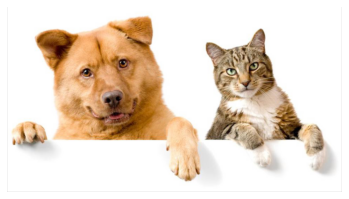

In [62]:
print('input image shape:', img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0));
plt.axis('off')
print('output image shape:', out_img.shape)
plt.imshow(out_img);
plt.axis('off')
plt.show()

FCN에서,  transposed convolutional layer는 bilinear보간의 upsampling으로 초기화하고 $1\times 1$ convolution layer의 경우 Xavier초기화를 사용한다.

In [17]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

# Training

In [ ]:
# 위에서 실행해둔게 있으면 재실행할 필요는 없음
# batch_size, crop_size = 32, (320, 480)
# train_iter, test_iter = load_data_voc(batch_size, crop_size)

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
# multiple GPU로 학습되도록 짜여진 함수
# net = nn.DataParallel(net, device_ids=devices).to(devices[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## **Prediction**

예측시에는 각 channel마다 input image를 표준화한 후, 정의된 CNN 모델에서 요구하는 input 형태인 4차원 형식으로 변환해야한다.

In [21]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

각 pixel의 예측 클래스를 시각화하기 위해 예측 클래스를 데이터 세트의 레이블 색상에 다시 매핑한다.

In [22]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

test set의 이미지는 size가 고정되어있지 않다. 정의한 모델은 stride = 32의 transposed convolutional layer를 사용하기 때문에, test set의 이미지 width와 height가 32로 나눠떨어지지 않는 경우 output이 input image와 다른 size일 수 있다. 이러한 문제를 대처하기 위해 width와 height가 32의 정수배인 직사각형 영역을 여러 개 잘라내고 이러한 각 영역의 pixel에 대해 개별적으로 forward propagation을 수행할 수 있다. 개별적 수행 후 이러한 직사각형 영역의 union은 input image를 완전히 덮어야한다. 같은 pixel이 여러 직사각형 영역으로 덮여있는 경우, softmax 함수에 입력해 클래스를 예측할 수 있다.

간단하게, 몇 개의 더 큰 test image를 읽고 좌상단 모서리에서 시작하여 예측을 위해 $320\times480$ 영역을 잘라낸다. 

실행결과는 줄별로 잘라낸 영역, 예측 결과, ground-truth 영역이 시각화된다.

In [4]:
test_images, test_labels = read_voc_images(voc_dir, False)

In [ ]:
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);